In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data.dataset import random_split
from PIL import Image


# Global plot settings
plt.rcParams['font.size'] = 14  # Font size for all plots
plt.rcParams['font.weight'] = 'bold'  # Bold font for all plots

# Define the device: Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for computation.")

Using cpu for computation.


In [2]:
# Load CSV file
csv_file_path = '/home/nico/Schreibtisch/CodingChallenge_v2/car_imgs_4000.csv'
dataframe = pd.read_csv(csv_file_path)

# Image Path
img_dir = '/home/nico/Schreibtisch/CodingChallenge_v2/imgs'

In [3]:
class CarDataset(Dataset): # Inherit Dataset class from pytorch
    def __init__(self, annotations_file, img_dir):
        self.img_labels = pd.read_csv(annotations_file)
        # Ensure label columns are numeric
        self.img_labels.iloc[:, 1:3] = self.img_labels.iloc[:, 1:3].apply(pd.to_numeric, errors='raise')
        self.img_dir = img_dir
        self.transform = transforms.Compose([   #transforms.compose for chain of transformations
            transforms.ToTensor(), # Conversion to torch tensor
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #pixel = (pixel - 0.5 )/0.5
        ])

    def __len__(self):
        return len(self.img_labels) # length of data set

    def __getitem__(self, idx): #provides image-label-pair for given index idx
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        label = torch.tensor(self.img_labels.iloc[idx, 1:3].astype(float).values, dtype=torch.float32)
        return image, label




# Instantiate the dataset
dataset = CarDataset(csv_file_path, img_dir)

# DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


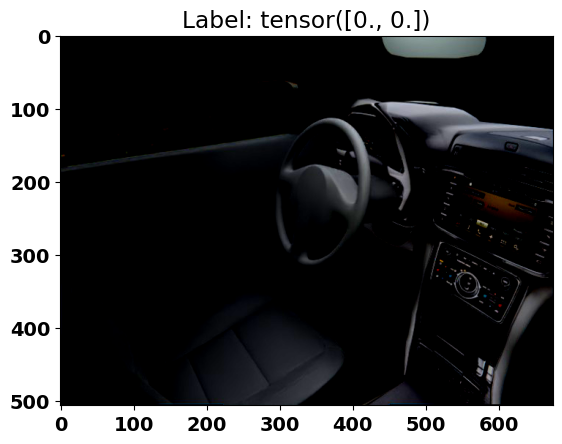

Shape of images: torch.Size([64, 3, 506, 674])
Shape of labels: torch.Size([64, 2])
tensor([[[-1.0000, -1.0000, -0.8588,  ..., -0.8118, -0.7882, -1.0000],
         [-1.0000, -0.9373, -0.4431,  ...,  0.0588, -0.3412, -0.9686],
         [-1.0000, -0.8980, -0.3020,  ...,  0.2235, -0.2157, -0.9686],
         ...,
         [-0.9765, -0.9216, -0.7176,  ..., -0.8588, -0.9137, -1.0000],
         [-1.0000, -1.0000, -0.9686,  ..., -0.9451, -0.9608, -0.9686],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9843, -0.9922]],

        [[-0.9059, -0.8118, -0.7098,  ..., -0.4039, -0.3961, -0.7647],
         [-0.9216, -0.7098, -0.3333,  ...,  0.3098,  0.0431, -0.5843],
         [-0.9529, -0.7412, -0.2627,  ...,  0.2863,  0.1686, -0.5922],
         ...,
         [-1.0000, -0.9608, -0.7882,  ..., -0.8588, -0.9059, -0.9922],
         [-0.9843, -0.9529, -0.9294,  ..., -0.9373, -0.9529, -0.9608],
         [-0.9686, -0.9765, -0.9529,  ..., -0.9922, -0.9765, -0.9843]],

        [[-0.6627, -0.5373, -0.3

In [4]:
# Function to show an image
def show_image(img, label):
    # Convert the tensor to a numpy array
    npimg = img.numpy()
    # Transpose the dimensions to match the expected format for matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f'Label: {label}')
    plt.show()

# Display the first few rows of the dataset
#print(dataframe.head())

# Get a batch of images
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Show the first image in the batch
show_image(images[0], labels[0])

print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)
print(images[5])
print("Labels:")
print(labels[5])

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__() # Calls constructor of nn.Module
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # Input channels x output channels, kernel ; padding = 1 zero at the edge
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Adjust the size to match your actual input image size
        dummy_input = torch.zeros(1, 3, 506, 674)  # batch size, RGB, 2D Image
        dummy_features = self.forward_features(dummy_input) # Calculation of dummy before dense layer
        in_features = dummy_features.view(-1).shape[0] #flatten to one dimension
        print(f"Flattened size: {in_features}")  # Debugging print

        self.fc1 = nn.Linear(in_features, 16)
        self.fc2 = nn.Linear(16, 2)

    def forward_features(self, x): #for dummy calculation
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x

    def forward(self, x): #for training calculation
        x = self.forward_features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [6]:
# Define the split sizes
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
model = SimpleCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 80
train_losses, val_losses = [], []
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))

    # Validation phase
    model.eval()  # Set the model to evaluation mode for validation
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_losses.append(val_loss / len(val_loader))
    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}')

    # Early stopping logic
    if val_losses[-1] < min_val_loss:
        min_val_loss = val_losses[-1]
        early_stop_count = 0  # reset the count if validation loss decreases
    else:
        early_stop_count += 1

    if early_stop_count >= 2:  # stop if validation loss increases for two consecutive epochs
        print("Early stopping triggered")
        break



Flattened size: 84672
Epoch 1, Train Loss: 0.21730261245234447, Validation Loss: 0.11886621788144111
Epoch 2, Train Loss: 0.10283911346711895, Validation Loss: 0.08482429273426532
Epoch 3, Train Loss: 0.07855293578044935, Validation Loss: 0.07153646238148212
Epoch 4, Train Loss: 0.06539400133558294, Validation Loss: 0.06785179451107978
Epoch 5, Train Loss: 0.05286746514453129, Validation Loss: 0.06275548525154591
Epoch 6, Train Loss: 0.03854778510603038, Validation Loss: 0.06644342131912709
Epoch 7, Train Loss: 0.027576737021180717, Validation Loss: 0.06810985766351223
Early stopping triggered


In [8]:
# Testing loop
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss}')

print(outputs.shape)

# Calculation of RMSE from the test loss
rmse_test = np.sqrt(test_loss)
print(f'Test RMSE: {rmse_test}')

Test Loss: 0.0694810040295124
torch.Size([24, 2])
Test RMSE: 0.26359249615554764


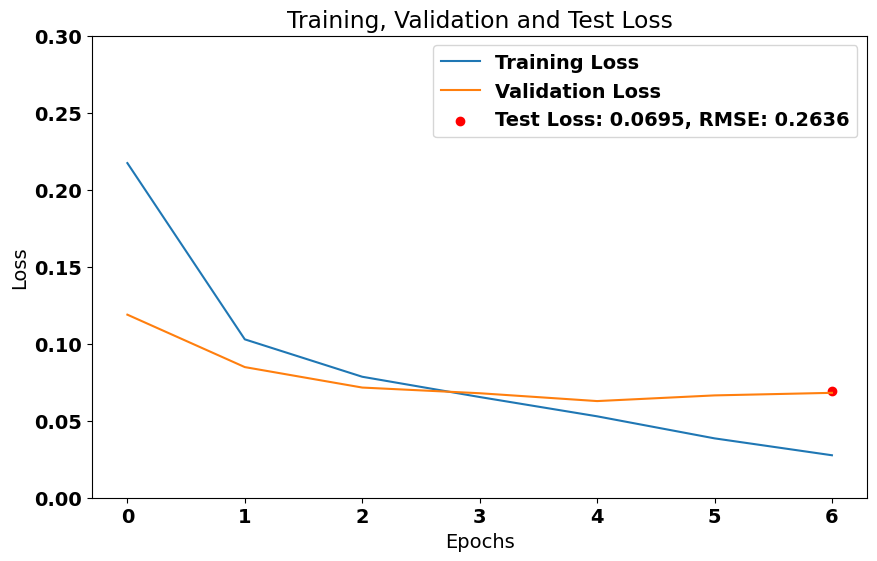

In [9]:
# Plot Training Curve (Loss)
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Plot the test loss as a point on the graph
# Assuming the test loss is plotted at the last epoch where validation occurred
last_epoch = len(val_losses) - 1
plt.scatter(last_epoch, test_loss, color='red', label=f'Test Loss: {test_loss:.4f}, RMSE: {rmse_test:.4f}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation and Test Loss')
plt.legend()
plt.ylim(0, 0.3)  # Set the upper y-axis limit
plt.savefig('loss_curves.pdf')
plt.show()

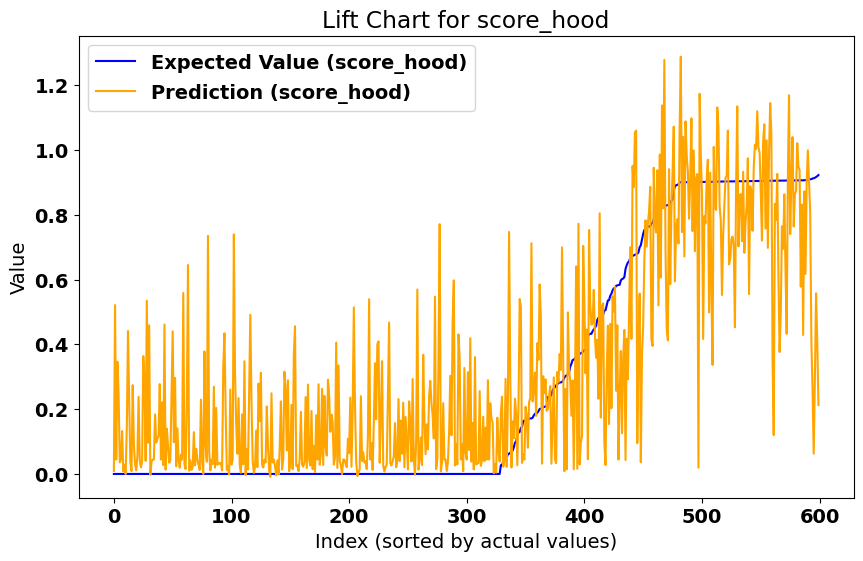

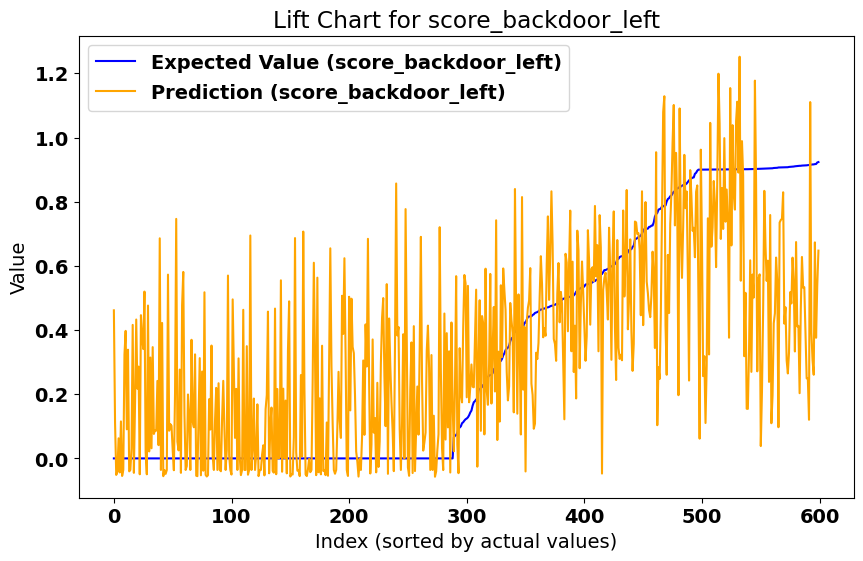

In [10]:
# Collecting all predictions and actual values from the test dataset
all_outputs = []
all_labels = []

model.eval()  # Switches the model to evaluation mode
with torch.no_grad():  # Disables gradient computation
    for images, labels in test_loader:  # Replace `test_loader` with your DataLoader for the test set
        images = images.to(device)  # Move images to the appropriate device
        outputs = model(images)
        all_outputs.append(outputs.cpu().numpy())  # Store predictions
        all_labels.append(labels.cpu().numpy())  # Store actual values

# Concatenating predictions and actual values from all batches
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Sorting data points for the lift chart based on actual values for "score_hood"
indices_hood = np.argsort(all_labels[:, 0])  # Sorting by "score_hood"
sorted_labels_hood = all_labels[indices_hood, 0]
sorted_outputs_hood = all_outputs[indices_hood, 0]

# Creating the lift chart for "score_hood"
plt.figure(figsize=(10, 6))
plt.plot(sorted_labels_hood, label='Expected Value (score_hood)', color='blue')
plt.plot(sorted_outputs_hood, label='Prediction (score_hood)', color='orange')
plt.title('Lift Chart for score_hood')
plt.xlabel('Index (sorted by actual values)')
plt.ylabel('Value')
plt.legend()
plt.savefig('score-hood.pdf')
plt.show()

# Sorting data points for the lift chart based on actual values for "score_backdoor_left"
indices_backdoor_left = np.argsort(all_labels[:, 1])  # Sorting by "score_backdoor_left"
sorted_labels_backdoor_left = all_labels[indices_backdoor_left, 1]
sorted_outputs_backdoor_left = all_outputs[indices_backdoor_left, 1]

# Creating the lift chart for "score_backdoor_left"
plt.figure(figsize=(10, 6))
plt.plot(sorted_labels_backdoor_left, label='Expected Value (score_backdoor_left)', color='blue')
plt.plot(sorted_outputs_backdoor_left, label='Prediction (score_backdoor_left)', color='orange')
plt.title('Lift Chart for score_backdoor_left')
plt.xlabel('Index (sorted by actual values)')
plt.ylabel('Value')
plt.legend()
plt.savefig('score-backdoor.pdf')
plt.show()
